# Entanglement entropy and Mutual Information analysis of Tmaze Active Inference Tensor Network




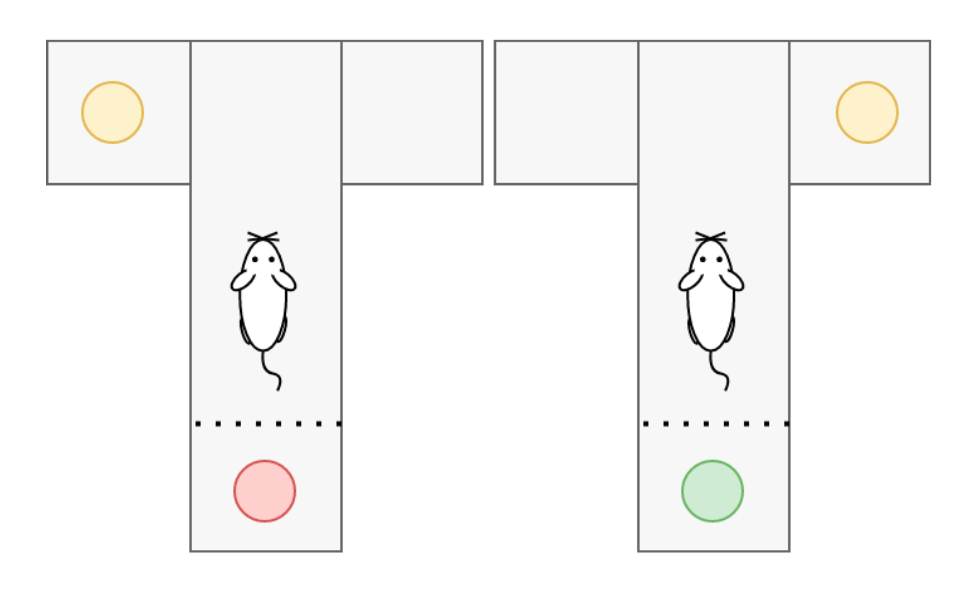







### A mouse has 24 possible observations given by its position [center, right, left, cue(down)] x reward [No reward, Win, Loss] x context [right, left]. The context determines in which position the reward is to be found. It is random, unless the mouse is in the cue position. The mouse has 4 actions [center, right, left, cue(down)]. The environment only runs for two time steps, so only two actions are performed


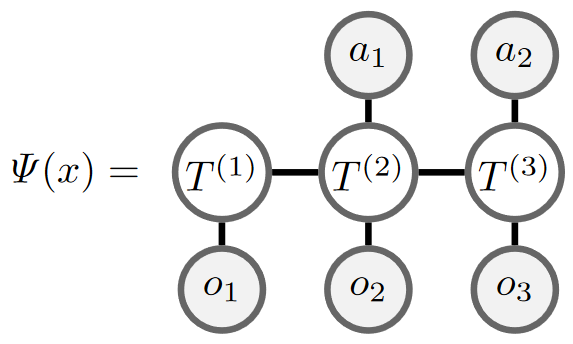

### A tensor network was trained to learn the generative model: P(o,a) of all possible actions and observations in the Tmaze environment. https://link.springer.com/content/pdf/10.1007%2F978-3-031-28719-0_20.pdf
### I will use the insights from https://arxiv.org/abs/2401.00867 to analyze the dependence (entanglement) between these variables. The objective is to show how Empowerment increases as information is gained.

In [1]:
%pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


# Load data

In [2]:
import torch as t
import tensornetwork as tn
import numpy as np
import os
from src import Utils as u

# Specify the path to the .pt file
model = "SamuelModel.pt"

file_path = 'Saved_Models/' + model

# Load the .pt file
mps = t.load(file_path, weights_only=False)
T1,T2,T3 = mps.matrices

T1 = T1.numpy()
T2 = T2.numpy()
T3 = T3.numpy()
print(T1.shape, T2.shape, T3.shape)

(1, 4, 24, 2) (2, 4, 24, 4) (4, 4, 24, 1)


# Convert Wauthier Ansatz to MPS with explicit hidden states
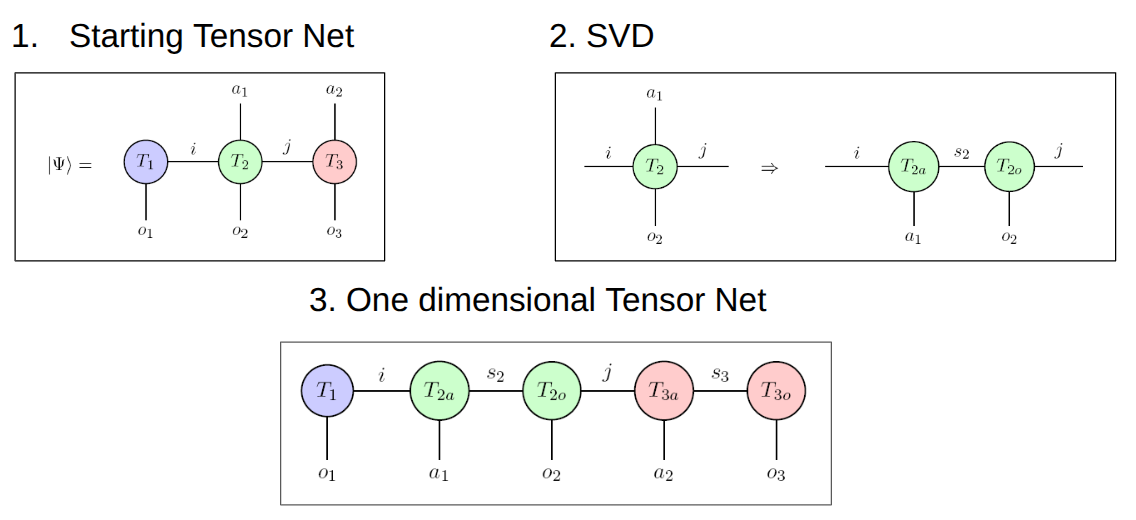

## Bring MPS into right gauge and add identity tensors to materialize hidden states

### T3

In [3]:


def svd_truncate(matrix, cutoff = 1e-2):

    U, S, Vh = np.linalg.svd(matrix, full_matrices=False)

    # Cutoff small singular values
    keep = min(len(S), np.sum(S > cutoff))

    U_trunc = U[:, :keep]
    S_trunc = S[:keep]
    Vh_trunc = Vh[:keep, :]

    return U_trunc, S_trunc, Vh_trunc, keep

U_trunc, S_trunc, Vh_trunc, s3 = svd_truncate(T3.reshape(16, 24))
# Pass singular values to the left
T3a = U_trunc @ np.diag(S_trunc)
T3a = T3a.reshape(4, 4, s3)

# Create 3rd-order identity tensor to extract hidden states
def delta(size):
    delta = np.zeros((size, size, size))
    for i in range(size):
        delta[i, i, i] = 1.0
    return delta

T3s = delta(s3)

# Keep unitary on the right so it becomes Identitiy when contracted with its conjugate transpose
T3o = Vh_trunc.reshape(s3, 24, 1)

print(T3a.shape, T3s.shape, T3o.shape)


(4, 4, 11) (11, 11, 11) (11, 24, 1)


### T2

In [4]:
T2_3 = tn.ncon([T2.reshape(8, 24,4), T3a], [[-1, -2, 1], [ 1, -3,  -4]])
U, S, Vh, j = svd_truncate(T2_3.reshape(8*24, 4*s3))

# Pass singular values to the left
T2ao = U @ np.diag(S)
T2ao = T2ao.reshape(8, 24, j)

T3a = Vh.reshape(j, 4, s3)

# Recover s2
U, S, Vh, s2 = svd_truncate(T2ao.reshape(8, 24*j))

# Pass singular values to the left
T2a = U @ np.diag(S)
T2a = T2a.reshape(2,4, s2)

T2s = delta(s2)

T2o = Vh.reshape(s2, 24, j)




### Remove irrelevant variables

In [5]:
# Fix inexistent action0 in T1
T1h = tn.ncon([T1[0], np.array([1, 0, 0, 0])], [[1, -1, -2], [1]])

# Fix initial observation
o1 = np.zeros((24)) # p = center, reward = None, Context = Right (irrelevant)
o1[0] = 1
T1h = tn.ncon([T1h, o1], [[1, -1], [1]])
T2h = tn.ncon([T1h, T2a], [[1], [1, -1, -2] ]).reshape(1, 4, s2)
T2h = T2h / np.sqrt(np.linalg.norm(T2h))



print("a1",T2h.shape, "s2",T2s.shape, "o2",T2o.shape, "a2",T3a.shape, "s3",T3s.shape, "o3",T3o.shape)
mps = [T2h, T2s, T2o, T3a, T3s, T3o]

a1 (1, 4, 8) s2 (8, 8, 8) o2 (8, 24, 4) a2 (4, 4, 11) s3 (11, 11, 11) o3 (11, 24, 1)


# Compute Reduced Density Matrix (RDM)
### An RDM is a description of a quantum subsystem, that contains information about iits entanglement to the rest of the total system. In our case, each variable is considered to be a subsystem. The RDM is obtained by summing over the other variables and ending up with a sort of Covariance matrix of our variables of interest. 

In [6]:
import tensornetwork as tn
def tensorNet(mps):

    # Convert MPS to TensorNetwork
    nodes = []
    conj_nodes = []
    for idx, tensor in enumerate(mps):
        nodes.append(tn.Node(tensor, name=f"node_{idx}"))
        conj_nodes.append(tn.Node(np.conj(tensor), name=f"conj_node_{idx}"))

    return nodes, conj_nodes

nodes, conj_nodes = tensorNet(mps)


 
 Initial sites: {0, 1}

 RDM tensor shape: (4, 8, 4, 8)


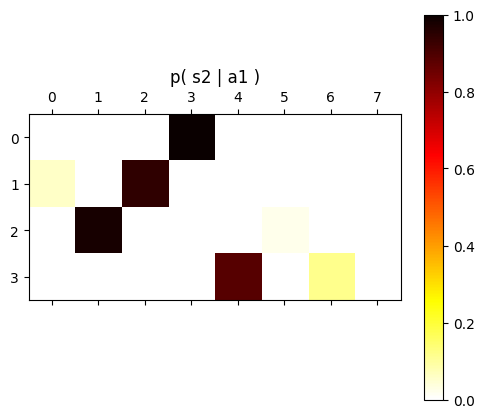

In [7]:
from scipy.stats import entropy
def von_neumann_entropy(rho, base=2):
    """Computes the von Neumann entropy of a density matrix."""
    # Filter out zero eigenvalues to avoid log(0)
    eigenvalues = np.linalg.eigvalsh(rho)
    non_zero_eigenvalues = eigenvalues[eigenvalues > 1e-12]
    return entropy(non_zero_eigenvalues, base=base)

def get_rdm(nodes, conj_nodes, sites):
    """
    Computes the reduced density matrix (RDM) for a given set of (ascending) sites.
    """

    print("\n \n Initial sites:", sites)

    # Due to left-canonicalization, we only need to contract up to the rightmost site.
    max_site = max(sites)
    nodes = nodes[:max_site + 1]
    conj_nodes = conj_nodes[:max_site + 1]
    #print("\n Nodes1:", nodes)

    # 1. Connect uninformative edges
    nodes[0][0] ^ conj_nodes[0][0]
    nodes[-1][2] ^ conj_nodes[-1][2]

    # 2. Connect the virtual "bond" indices of the MPS chain
    for i in range(max_site):
        nodes[i][2] ^ nodes[i+1][0]
        conj_nodes[i][2] ^ conj_nodes[i+1][0]

    # Define the open edges for the RDM
    open_edges = []
    for site_idx in sites:
        open_edges.append(nodes[site_idx][1])
    for site_idx in sites:
        open_edges.append(conj_nodes[site_idx][1])

    # Create a list of sites to be contracted (traced out)
    sites_to_contract = set(range(max_site + 1)) - sites

    # 3. Connect the physical indices of the sites to be traced out
    for i in sites_to_contract:
        nodes[i][1] ^ conj_nodes[i][1]

    # Contract the network to get the RDM tensor
    rdm_node = tn.contractors.auto(nodes + conj_nodes, output_edge_order=open_edges)
    rdm_tensor = rdm_node.tensor

    # Multiply the first half of the shape vector to get the matrix dimensions
    rdm_rows = int(np.prod(rdm_tensor.shape[:len(rdm_tensor.shape)//2]))
    print("\n RDM tensor shape:", rdm_tensor.shape)

    # Reshape into a matrix
    rdm = rdm_tensor.reshape(rdm_rows, rdm_rows)

    return rdm

rho_a1s2 = get_rdm(nodes, conj_nodes, {0,1})
rho_a1s2 = rho_a1s2 / np.trace(rho_a1s2)  # Normalize RDM

p_a1s2 = np.real(np.diag(rho_a1s2)).reshape(4, -1)
# Obtain conditional distribution p(s2|a1 ) by normalizing over s2 for each a1
p_s2_given_a1 = p_a1s2 / np.sum(p_a1s2, axis=1, keepdims=True)
u.plot_distribution(p_s2_given_a1, title="p( s2 | a1 )")


 
 Initial sites: {0, 2}

 RDM tensor shape: (4, 24, 4, 24)


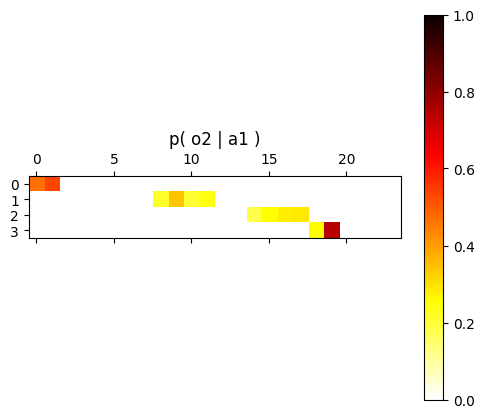

In [8]:
# Compute RDM for a1 and o2 (sites 0 and 2)
rho_a1o2 = get_rdm(nodes, conj_nodes, {0, 2})
rho_a1o2 = rho_a1o2 / np.trace(rho_a1o2)  # Normalize RDM

# Extract joint diagonal P(A1,O2) and conditional P(O2|A1)
p_a1o2 = np.real(np.diag(rho_a1o2)).reshape(4, -1)
p_o2_given_a1 = p_a1o2 / np.sum(p_a1o2, axis=1, keepdims=True)

u.plot_distribution(p_o2_given_a1, title="p( o2 | a1 )")


 
 Initial sites: {0, 2}

 RDM tensor shape: (4, 24, 4, 24)


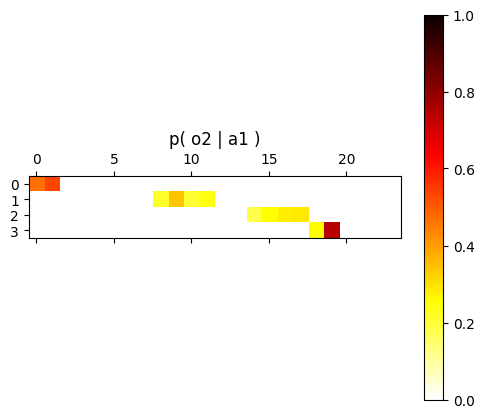

In [9]:
rho_a1s2 = get_rdm(nodes, conj_nodes, {0,2})
rho_a1s2 = rho_a1s2 / np.trace(rho_a1s2)  # Normalize RDM

p_a1s2 = np.real(np.diag(rho_a1s2)).reshape(4, -1)
# Obtain conditional distribution p(s2|a1 ) by normalizing over s2 for each a1
p_s2_given_a1 = p_a1s2 / np.sum(p_a1s2, axis=1, keepdims=True)
u.plot_distribution(p_s2_given_a1, title="p( o2 | a1 )")


 
 Initial sites: {3, 5}

 RDM tensor shape: (4, 24, 4, 24)


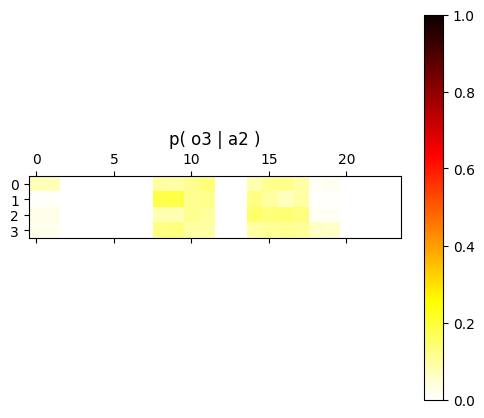

In [10]:
rho_a2o3 = get_rdm(nodes, conj_nodes, {3,5})
rho_a2o3 = rho_a2o3 / np.trace(rho_a2o3)  # Normalize RDM

p_a2o3 = np.real(np.diag(rho_a2o3)).reshape(4, -1)
# Obtain conditional distribution p(o3|a2 ) by normalizing over o3 for each a2
p_o3_given_a2 = p_a2o3 / np.sum(p_a2o3, axis=1, keepdims=True)
u.plot_distribution(p_o3_given_a2, title="p( o3 | a2 )")

In [15]:
def mutual_information(p_o_given_a, p_a, base=2):
    """
    Compute mutual information I(A;O) between actions and observations.
    
    Parameters:
    -----------
    p_o_given_a : numpy.ndarray, shape (n_actions, n_observations)
        Conditional probability matrix P(O|A)
    p_a : numpy.ndarray, shape (n_actions,)
        Marginal probability distribution P(A)
    base : float, default=2
        Base for logarithm (2 for bits, np.e for nats)
    
    Returns:
    --------
    mi : float
        Mutual information I(A;O) = H(A) - H(A|O)
    """
    
    # Check probabilities are normalized and non-negative
    assert np.allclose(np.sum(p_a), 1.0, atol=1e-12), f"p_a must sum to 1 (sum={np.sum(p_a)})"
    assert np.all(p_a >= -1e-12), "p_a must be non-negative"
    row_sums = np.sum(p_o_given_a, axis=1)
    assert np.allclose(row_sums, 1.0, atol=1e-12), f"Each row of p_o_given_a must sum to 1 (sums={row_sums})"
    assert np.all(p_o_given_a >= -1e-12), "p_o_given_a must be non-negative"
    
    # Compute joint distribution P(A,O) = P(O|A) * P(A)
    p_a = np.asarray(p_a).reshape(-1)
    assert p_o_given_a.shape[0] == p_a.shape[0], f"row mismatch: {p_o_given_a.shape[0]} vs {p_a.shape[0]}"
    p_joint = p_o_given_a * p_a[:, None]
    #u.plot_distribution(p_joint, title="Joint Distribution P(A,O)")
    # Compute marginal P(O) = sum_a P(A,O)
    p_o = np.sum(p_joint, axis=0)
    u.plot_distribution(p_o[np.newaxis,:], title="Marginal Distribution P(O)")
    # Compute H(O) - entropy of observations

    h_o = entropy(p_o, base=base)
    
    # Compute H(O|A) - conditional entropy
    h_o_given_a = entropy(p_o_given_a, base=base, axis=1) 
    h_o_given_a = np.sum(h_o_given_a * p_a)

    # Mutual Information: I(A;O) = H(O) - H(O|A)
    mi = h_o - h_o_given_a
    

    return mi

def empowerment_classical(p_o_given_a):
    """
    Compute classical empowerment as the maximum mutual information over all possible P(A).
    
    Parameters:
    -----------
    p_o_given_a : numpy.ndarray, shape (n_actions, n_observations)
        Conditional probability matrix P(O|A)
    base : float, default=2
        Base for logarithm
    
    Returns:
    --------
    max_mi : float
        Maximum mutual information (empowerment)
    optimal_p_a : numpy.ndarray
        Optimal action distribution that achieves maximum MI
    """
    
    n_actions = p_o_given_a.shape[0]
    
    # Try different action distributions to find maximum MI
    max_mi = 0.0
    optimal_p_a = None
    
    # Start with uniform distribution
    p_a_uniform = np.ones(n_actions) / n_actions
    mi_uniform = mutual_information(p_o_given_a, p_a_uniform)
    max_mi = mi_uniform
    optimal_p_a = p_a_uniform.copy()
    
    # Try some other distributions (this is a simplified search)
    # For optimal solution, you'd need to solve the optimization problem
    from scipy.optimize import minimize
    
    def negative_mi(p_a_flat):
        # Ensure probabilities sum to 1 and are non-negative
        p_a = np.abs(p_a_flat)
        p_a = p_a / np.sum(p_a)
        return -mutual_information(p_o_given_a, p_a)
    
    # Optimize to find maximum MI
    result = minimize(negative_mi, p_a_uniform, method='SLSQP',
                     constraints={'type': 'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1})
    
    if result.success:
        optimal_p_a = np.abs(result.x)
        optimal_p_a = optimal_p_a / np.sum(optimal_p_a)
        max_mi = mutual_information(p_o_given_a, optimal_p_a)

    return max_mi, optimal_p_a



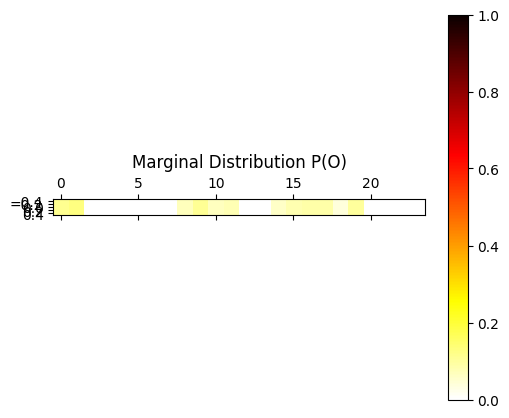

Mutual Information of environment I(A1;O2) = 1.933961 bits


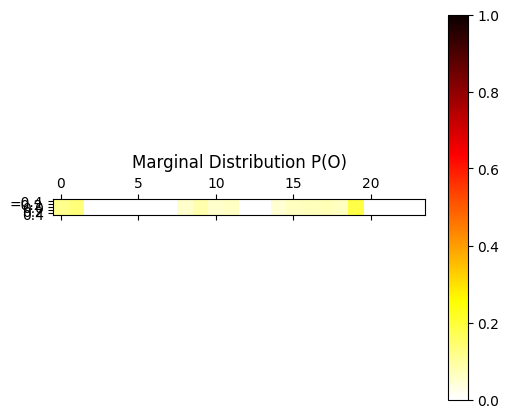

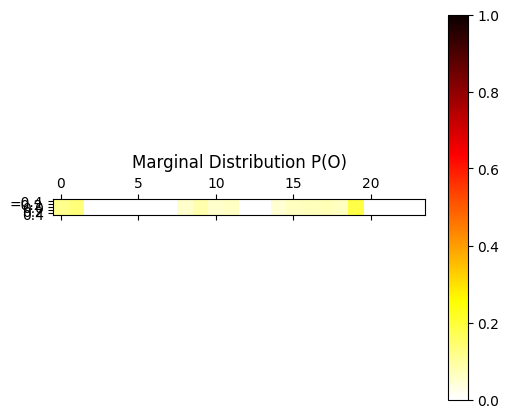

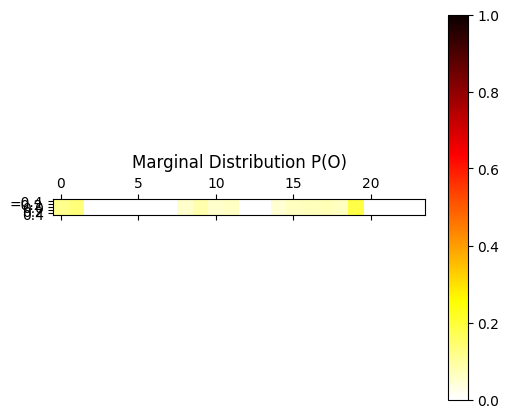

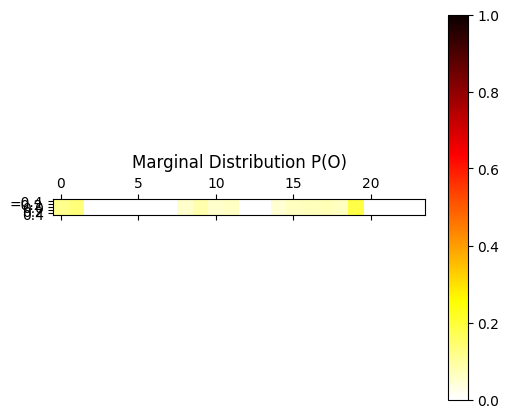

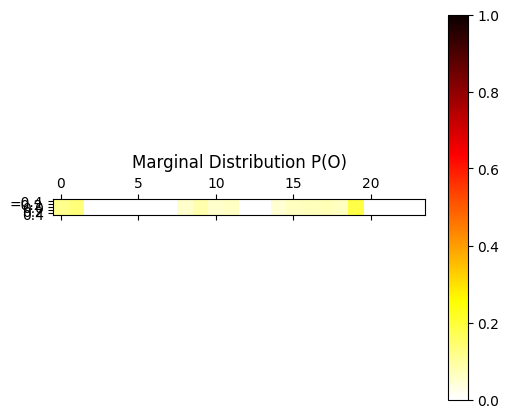

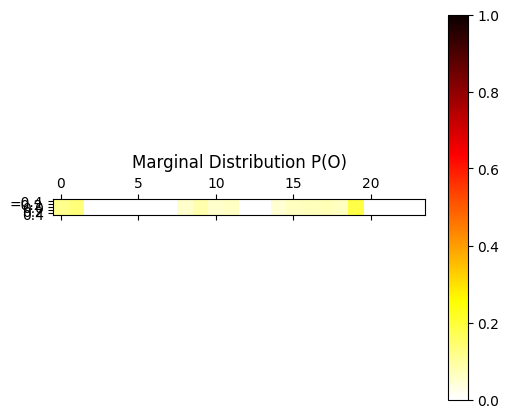

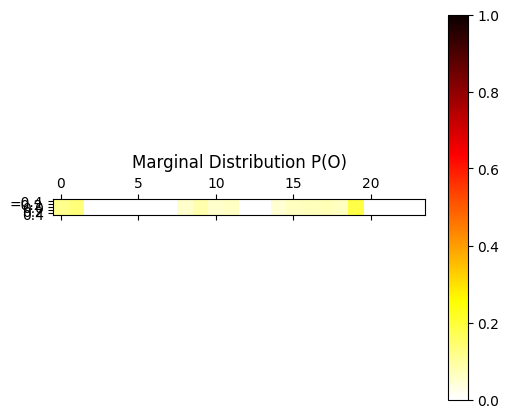

Empowerment (max MI) = 2.000000 bits
Optimal P(A1) = [0.25 0.25 0.25 0.25]


In [16]:
# Compute RDM and empowerment for A1 and O2

# Dimensions from existing arrays
dim_a1 = p_a1o2.shape[0]
dim_o2 = p_a1o2.shape[1]

# Trace out O2 from rho_a1o2 to get rho_a1
rho_a1 = rho_a1o2.reshape(dim_a1, dim_o2, dim_a1, dim_o2)
rho_a1 = np.trace(rho_a1, axis1=1, axis2=3)

# Extract marginal P(A1)
p_a1 = np.sum(p_a1o2, axis=1)

# Compute mutual information I(A1;O2)
mi_a1_o2 = mutual_information(p_o2_given_a1, p_a1)
print(f"Mutual Information of environment I(A1;O2) = {mi_a1_o2:.6f} bits")

# Compute classical empowerment (max MI) and optimal P(A1)
empowerment_a1_o2, optimal_p_a1 = empowerment_classical(p_o2_given_a1)
print(f"Empowerment (max MI) = {empowerment_a1_o2:.6f} bits")
print(f"Optimal P(A1) = {optimal_p_a1}")


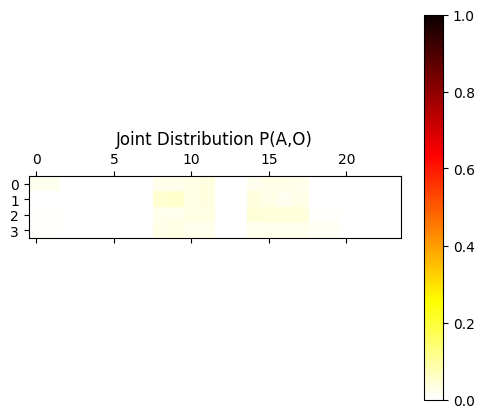

p_o: [3.00975448e-02 2.99283242e-02 1.12508507e-05 9.29523863e-06
 8.88016999e-06 7.15141833e-06 6.34946524e-06 7.32945740e-06
 1.19964441e-01 1.21723134e-01 1.07613626e-01 1.10008961e-01
 7.40382897e-06 8.52917267e-06 1.13083465e-01 1.11779813e-01
 1.06285616e-01 1.05131782e-01 2.21998750e-02 2.20881505e-02
 6.72638302e-06 8.91194446e-06 8.47557119e-06 4.96467478e-06]
H(O): 3.376262804820198
H(O|A): 3.292315683159625
0.08394712166057294
Mutual Information I(A2;O3) = 0.0839 bits


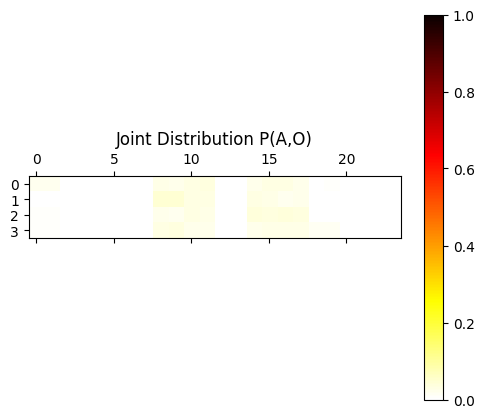

p_o: [3.11532426e-02 3.09737309e-02 1.15362144e-05 9.37948849e-06
 9.00657959e-06 7.25764365e-06 6.40660070e-06 7.54072515e-06
 1.19188229e-01 1.21196333e-01 1.07003028e-01 1.09839192e-01
 7.50008278e-06 8.72696861e-06 1.10743857e-01 1.11274780e-01
 1.06525858e-01 1.04459508e-01 2.38454782e-02 2.37000099e-02
 6.83589178e-06 9.01427551e-06 8.54367758e-06 5.00536452e-06]
H(O): 3.3877113678473045
H(O|A): 3.3043549979435722


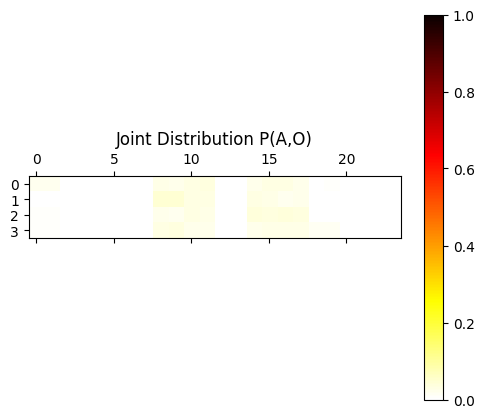

p_o: [3.11532426e-02 3.09737309e-02 1.15362144e-05 9.37948849e-06
 9.00657959e-06 7.25764365e-06 6.40660070e-06 7.54072515e-06
 1.19188229e-01 1.21196333e-01 1.07003028e-01 1.09839192e-01
 7.50008278e-06 8.72696861e-06 1.10743857e-01 1.11274780e-01
 1.06525858e-01 1.04459508e-01 2.38454782e-02 2.37000099e-02
 6.83589178e-06 9.01427551e-06 8.54367758e-06 5.00536452e-06]
H(O): 3.3877113678473045
H(O|A): 3.3043549979435722


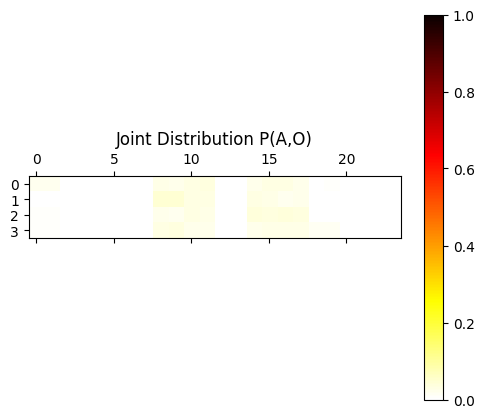

p_o: [3.11532432e-02 3.09737316e-02 1.15362144e-05 9.37948848e-06
 9.00657955e-06 7.25764363e-06 6.40660068e-06 7.54072514e-06
 1.19188229e-01 1.21196333e-01 1.07003029e-01 1.09839192e-01
 7.50008279e-06 8.72696861e-06 1.10743856e-01 1.11274780e-01
 1.06525858e-01 1.04459508e-01 2.38454780e-02 2.37000098e-02
 6.83589177e-06 9.01427551e-06 8.54367756e-06 5.00536452e-06]
H(O): 3.387711369645276
H(O|A): 3.304354999641986


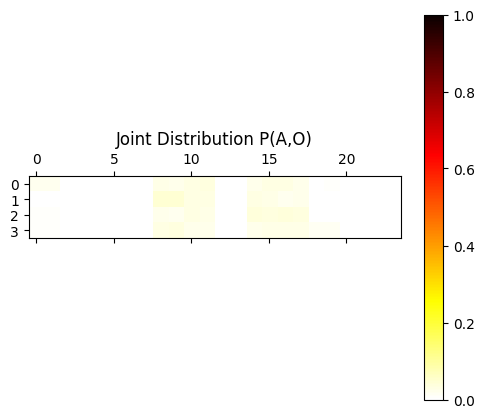

p_o: [3.11532422e-02 3.09737306e-02 1.15362143e-05 9.37948845e-06
 9.00657955e-06 7.25764362e-06 6.40660068e-06 7.54072510e-06
 1.19188230e-01 1.21196334e-01 1.07003029e-01 1.09839192e-01
 7.50008275e-06 8.72696856e-06 1.10743857e-01 1.11274780e-01
 1.06525857e-01 1.04459508e-01 2.38454779e-02 2.37000097e-02
 6.83589175e-06 9.01427546e-06 8.54367755e-06 5.00536450e-06]
H(O): 3.3877113651656994
H(O|A): 3.304354994665549


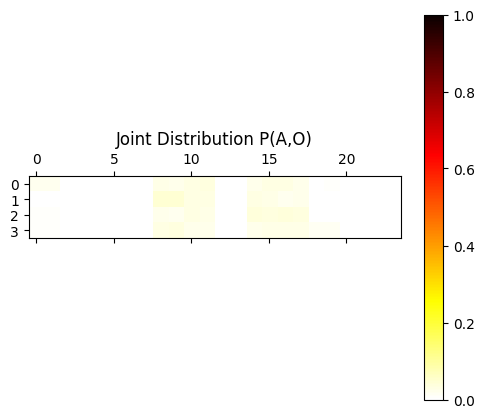

p_o: [3.11532425e-02 3.09737308e-02 1.15362144e-05 9.37948852e-06
 9.00657962e-06 7.25764365e-06 6.40660071e-06 7.54072514e-06
 1.19188229e-01 1.21196332e-01 1.07003029e-01 1.09839191e-01
 7.50008279e-06 8.72696860e-06 1.10743857e-01 1.11274780e-01
 1.06525858e-01 1.04459509e-01 2.38454780e-02 2.37000098e-02
 6.83589179e-06 9.01427554e-06 8.54367760e-06 5.00536454e-06]
H(O): 3.3877113670666126
H(O|A): 3.3043549975575


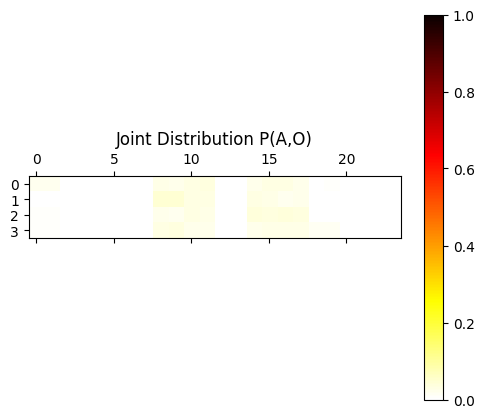

p_o: [3.11532425e-02 3.09737308e-02 1.15362145e-05 9.37948853e-06
 9.00657965e-06 7.25764369e-06 6.40660073e-06 7.54072521e-06
 1.19188229e-01 1.21196333e-01 1.07003028e-01 1.09839191e-01
 7.50008280e-06 8.72696865e-06 1.10743856e-01 1.11274780e-01
 1.06525858e-01 1.04459508e-01 2.38454787e-02 2.37000104e-02
 6.83589182e-06 9.01427555e-06 8.54367761e-06 5.00536454e-06]
H(O): 3.3877113695116305
H(O|A): 3.304354999909253


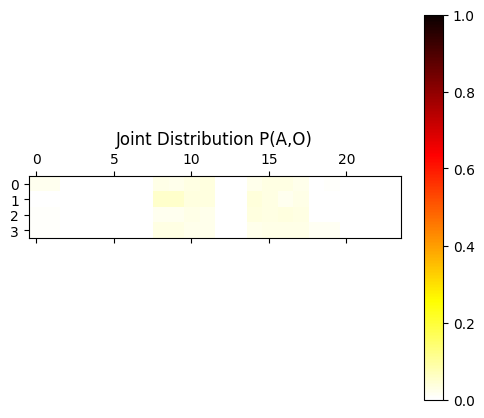

p_o: [3.08515626e-02 3.06780949e-02 1.13173780e-05 9.17714971e-06
 8.74855424e-06 7.11967156e-06 6.26856960e-06 7.36352486e-06
 1.22503721e-01 1.24573833e-01 1.07485321e-01 1.10851853e-01
 7.37268484e-06 8.54821220e-06 1.10361699e-01 1.10281859e-01
 1.03960216e-01 1.03127209e-01 2.26264520e-02 2.26035279e-02
 6.68306785e-06 8.78797611e-06 8.37735596e-06 4.88733095e-06]
H(O): 3.3801501304364576
H(O|A): 3.2943299932745194


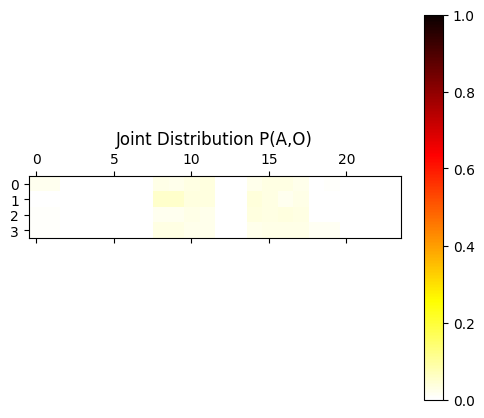

p_o: [3.08515633e-02 3.06780955e-02 1.13173780e-05 9.17714970e-06
 8.74855421e-06 7.11967154e-06 6.26856959e-06 7.36352486e-06
 1.22503721e-01 1.24573832e-01 1.07485321e-01 1.10851853e-01
 7.37268485e-06 8.54821220e-06 1.10361698e-01 1.10281859e-01
 1.03960216e-01 1.03127209e-01 2.26264519e-02 2.26035278e-02
 6.68306784e-06 8.78797611e-06 8.37735594e-06 4.88733095e-06]
H(O): 3.380150132374842
H(O|A): 3.294329995122318


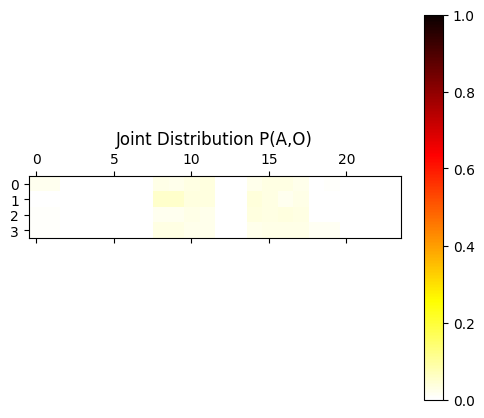

p_o: [3.08515623e-02 3.06780945e-02 1.13173779e-05 9.17714967e-06
 8.74855420e-06 7.11967153e-06 6.26856958e-06 7.36352482e-06
 1.22503722e-01 1.24573834e-01 1.07485321e-01 1.10851853e-01
 7.37268481e-06 8.54821216e-06 1.10361699e-01 1.10281859e-01
 1.03960216e-01 1.03127209e-01 2.26264518e-02 2.26035277e-02
 6.68306783e-06 8.78797606e-06 8.37735593e-06 4.88733093e-06]
H(O): 3.3801501277227137
H(O|A): 3.2943299901458807


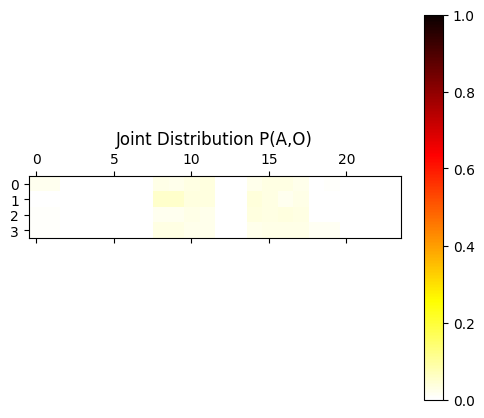

p_o: [3.08515625e-02 3.06780948e-02 1.13173779e-05 9.17714974e-06
 8.74855427e-06 7.11967156e-06 6.26856962e-06 7.36352485e-06
 1.22503720e-01 1.24573832e-01 1.07485321e-01 1.10851853e-01
 7.37268485e-06 8.54821220e-06 1.10361699e-01 1.10281859e-01
 1.03960217e-01 1.03127210e-01 2.26264519e-02 2.26035278e-02
 6.68306786e-06 8.78797614e-06 8.37735598e-06 4.88733097e-06]
H(O): 3.380150129834648
H(O|A): 3.294329993037832


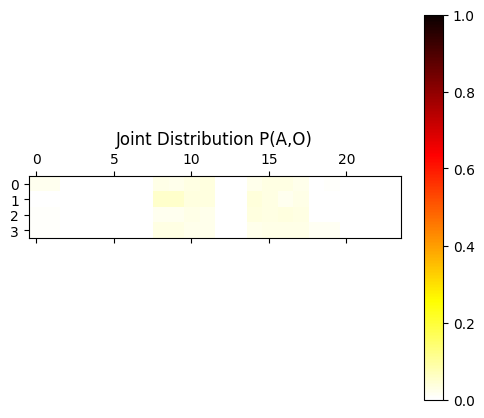

p_o: [3.08515625e-02 3.06780948e-02 1.13173780e-05 9.17714975e-06
 8.74855431e-06 7.11967160e-06 6.26856963e-06 7.36352492e-06
 1.22503721e-01 1.24573833e-01 1.07485321e-01 1.10851853e-01
 7.37268486e-06 8.54821225e-06 1.10361699e-01 1.10281859e-01
 1.03960216e-01 1.03127209e-01 2.26264526e-02 2.26035284e-02
 6.68306789e-06 8.78797615e-06 8.37735599e-06 4.88733097e-06]
H(O): 3.380150132281822
H(O|A): 3.2943299953895853


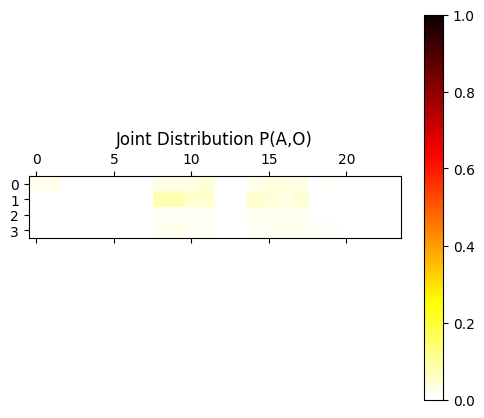

p_o: [3.05262040e-02 3.03736161e-02 1.05440333e-05 8.40530716e-06
 7.73860734e-06 6.58678524e-06 5.73109838e-06 6.70840894e-06
 1.34598413e-01 1.36852311e-01 1.09321534e-01 1.15062515e-01
 6.90774494e-06 7.89516058e-06 1.08106882e-01 1.06430736e-01
 9.43922639e-02 9.77440025e-02 1.80004375e-02 1.85043632e-02
 6.10117672e-06 7.93167665e-06 7.73220578e-06 4.43880616e-06]
H(O): 3.3495265421315206
H(O|A): 3.2595105703068876


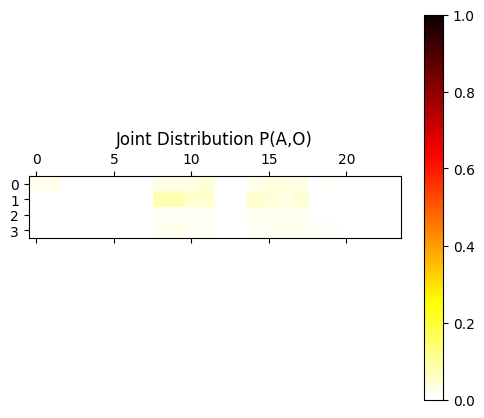

p_o: [3.05262046e-02 3.03736167e-02 1.05440333e-05 8.40530717e-06
 7.73860732e-06 6.58678523e-06 5.73109837e-06 6.70840895e-06
 1.34598412e-01 1.36852311e-01 1.09321534e-01 1.15062515e-01
 6.90774496e-06 7.89516060e-06 1.08106882e-01 1.06430736e-01
 9.43922642e-02 9.77440024e-02 1.80004374e-02 1.85043632e-02
 6.10117672e-06 7.93167666e-06 7.73220578e-06 4.43880616e-06]
H(O): 3.3495265446326865
H(O|A): 3.259510572673536


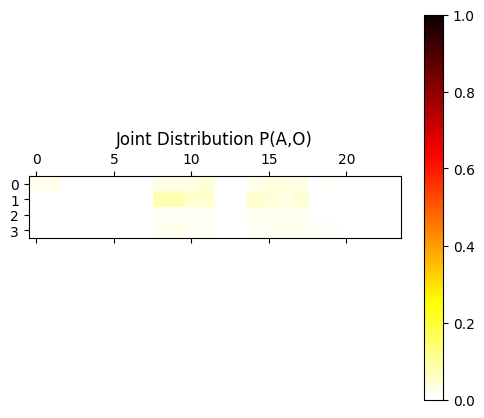

p_o: [3.05262036e-02 3.03736157e-02 1.05440332e-05 8.40530714e-06
 7.73860731e-06 6.58678522e-06 5.73109836e-06 6.70840892e-06
 1.34598414e-01 1.36852312e-01 1.09321535e-01 1.15062515e-01
 6.90774492e-06 7.89516055e-06 1.08106882e-01 1.06430736e-01
 9.43922634e-02 9.77440024e-02 1.80004374e-02 1.85043630e-02
 6.10117670e-06 7.93167662e-06 7.73220576e-06 4.43880614e-06]
H(O): 3.3495265394382745
H(O|A): 3.259510567697099


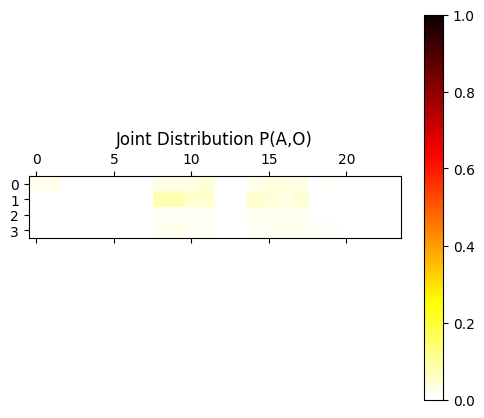

p_o: [3.05262039e-02 3.03736160e-02 1.05440333e-05 8.40530720e-06
 7.73860738e-06 6.58678525e-06 5.73109840e-06 6.70840895e-06
 1.34598412e-01 1.36852310e-01 1.09321534e-01 1.15062515e-01
 6.90774496e-06 7.89516059e-06 1.08106883e-01 1.06430737e-01
 9.43922646e-02 9.77440030e-02 1.80004375e-02 1.85043631e-02
 6.10117674e-06 7.93167669e-06 7.73220581e-06 4.43880618e-06]
H(O): 3.3495265423103726
H(O|A): 3.2595105705890495


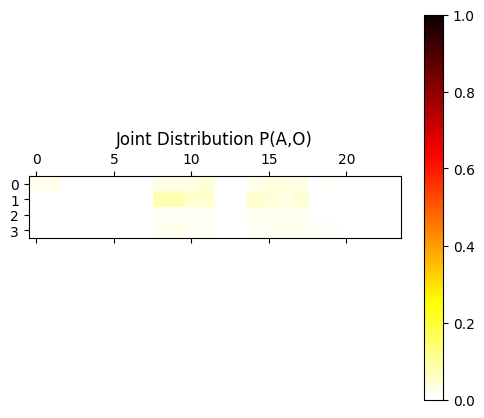

p_o: [3.05262038e-02 3.03736159e-02 1.05440333e-05 8.40530721e-06
 7.73860742e-06 6.58678529e-06 5.73109842e-06 6.70840902e-06
 1.34598413e-01 1.36852311e-01 1.09321534e-01 1.15062515e-01
 6.90774497e-06 7.89516065e-06 1.08106882e-01 1.06430736e-01
 9.43922641e-02 9.77440026e-02 1.80004381e-02 1.85043638e-02
 6.10117677e-06 7.93167670e-06 7.73220583e-06 4.43880618e-06]
H(O): 3.349526544820766
H(O|A): 3.2595105729408034


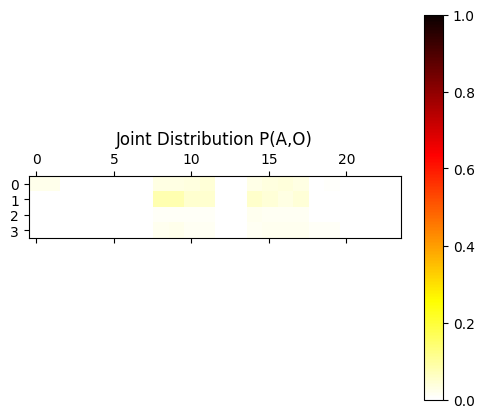

p_o: [3.10378538e-02 3.08835615e-02 1.05866590e-05 8.39475670e-06
 7.71441144e-06 6.58203451e-06 5.71833087e-06 6.72596494e-06
 1.34563350e-01 1.36826364e-01 1.09296423e-01 1.15320951e-01
 6.91684775e-06 7.91501063e-06 1.07388395e-01 1.06238208e-01
 9.42712582e-02 9.73771997e-02 1.80836589e-02 1.86260495e-02
 6.09917618e-06 7.92434626e-06 7.71798794e-06 4.43252435e-06]
H(O): 3.351816484394028
H(O|A): 3.261648421154057


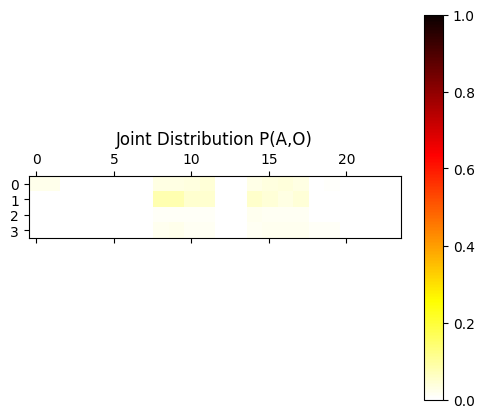

p_o: [3.10378545e-02 3.08835622e-02 1.05866590e-05 8.39475670e-06
 7.71441142e-06 6.58203450e-06 5.71833087e-06 6.72596495e-06
 1.34563349e-01 1.36826363e-01 1.09296423e-01 1.15320951e-01
 6.91684776e-06 7.91501065e-06 1.07388395e-01 1.06238208e-01
 9.42712586e-02 9.73771995e-02 1.80836588e-02 1.86260494e-02
 6.09917618e-06 7.92434627e-06 7.71798794e-06 4.43252436e-06]
H(O): 3.351816486825959
H(O|A): 3.2616484234888494


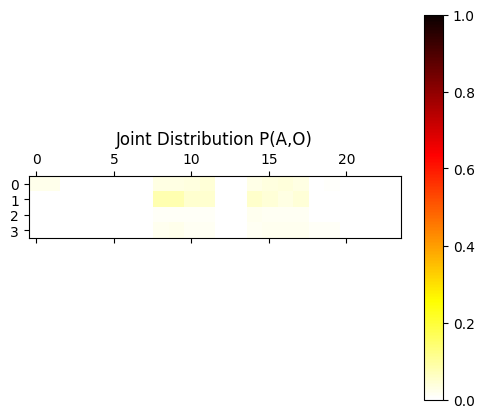

p_o: [3.10378535e-02 3.08835612e-02 1.05866590e-05 8.39475667e-06
 7.71441141e-06 6.58203449e-06 5.71833086e-06 6.72596491e-06
 1.34563350e-01 1.36826365e-01 1.09296423e-01 1.15320951e-01
 6.91684772e-06 7.91501060e-06 1.07388396e-01 1.06238208e-01
 9.42712578e-02 9.73771996e-02 1.80836587e-02 1.86260493e-02
 6.09917616e-06 7.92434622e-06 7.71798792e-06 4.43252434e-06]
H(O): 3.3518164816875617
H(O|A): 3.2616484185124115


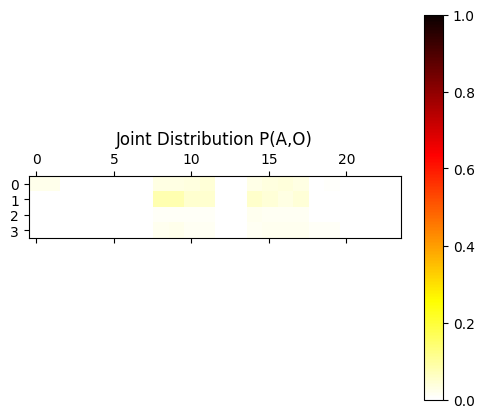

p_o: [3.10378537e-02 3.08835614e-02 1.05866590e-05 8.39475674e-06
 7.71441148e-06 6.58203452e-06 5.71833090e-06 6.72596494e-06
 1.34563349e-01 1.36826363e-01 1.09296423e-01 1.15320950e-01
 6.91684776e-06 7.91501064e-06 1.07388396e-01 1.06238209e-01
 9.42712589e-02 9.73772002e-02 1.80836589e-02 1.86260494e-02
 6.09917620e-06 7.92434630e-06 7.71798797e-06 4.43252438e-06]
H(O): 3.351816484555873
H(O|A): 3.261648421404363


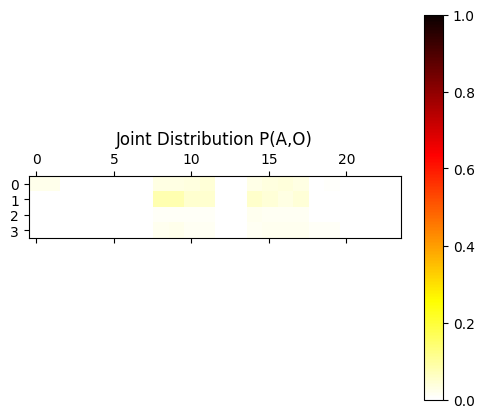

p_o: [3.10378537e-02 3.08835614e-02 1.05866591e-05 8.39475674e-06
 7.71441152e-06 6.58203456e-06 5.71833091e-06 6.72596501e-06
 1.34563350e-01 1.36826364e-01 1.09296422e-01 1.15320950e-01
 6.91684777e-06 7.91501069e-06 1.07388395e-01 1.06238208e-01
 9.42712584e-02 9.73771997e-02 1.80836595e-02 1.86260500e-02
 6.09917623e-06 7.92434630e-06 7.71798799e-06 4.43252437e-06]
H(O): 3.3518164870464675
H(O|A): 3.2616484237561165


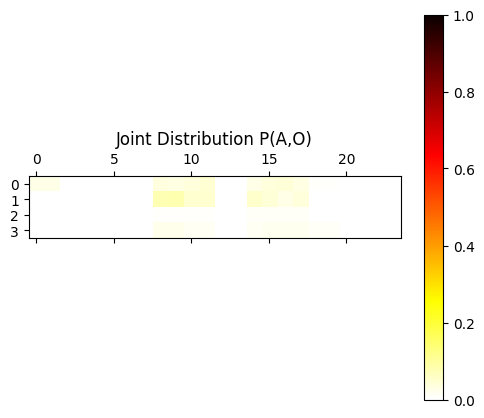

p_o: [3.28278216e-02 3.26668940e-02 1.07512706e-05 8.35699386e-06
 7.63488944e-06 6.57215551e-06 5.67463031e-06 6.80154733e-06
 1.34613930e-01 1.36952690e-01 1.09157641e-01 1.16211606e-01
 6.95073455e-06 7.99560521e-06 1.04663095e-01 1.05449858e-01
 9.36971917e-02 9.59720215e-02 1.85146766e-02 1.91857632e-02
 6.09736436e-06 7.89779494e-06 7.66895404e-06 4.40869551e-06]
H(O): 3.3600421171581254
H(O|A): 3.2696137669691927


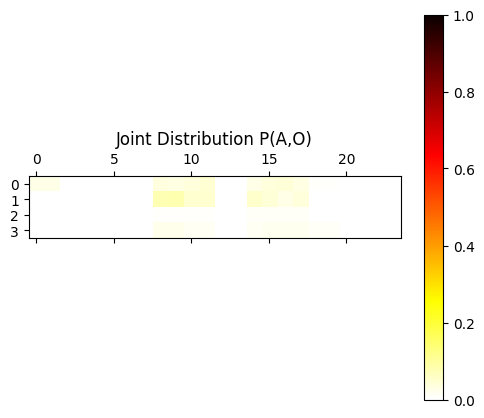

p_o: [3.28278222e-02 3.26668946e-02 1.07512707e-05 8.35699386e-06
 7.63488942e-06 6.57215550e-06 5.67463030e-06 6.80154734e-06
 1.34613930e-01 1.36952690e-01 1.09157641e-01 1.16211606e-01
 6.95073456e-06 7.99560523e-06 1.04663095e-01 1.05449858e-01
 9.36971921e-02 9.59720214e-02 1.85146765e-02 1.91857632e-02
 6.09736436e-06 7.89779495e-06 7.66895403e-06 4.40869551e-06]
H(O): 3.360042119356146
H(O|A): 3.269613769185292


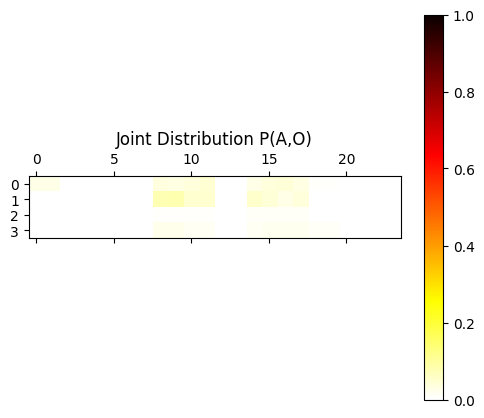

p_o: [3.28278212e-02 3.26668936e-02 1.07512706e-05 8.35699383e-06
 7.63488942e-06 6.57215550e-06 5.67463029e-06 6.80154730e-06
 1.34613931e-01 1.36952691e-01 1.09157641e-01 1.16211606e-01
 6.95073452e-06 7.99560518e-06 1.04663096e-01 1.05449858e-01
 9.36971913e-02 9.59720215e-02 1.85146764e-02 1.91857630e-02
 6.09736434e-06 7.89779490e-06 7.66895402e-06 4.40869549e-06]
H(O): 3.360042114404127
H(O|A): 3.269613764208854


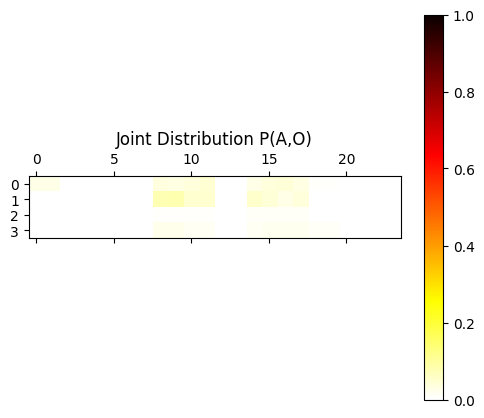

p_o: [3.28278215e-02 3.26668939e-02 1.07512706e-05 8.35699389e-06
 7.63488948e-06 6.57215553e-06 5.67463033e-06 6.80154733e-06
 1.34613929e-01 1.36952689e-01 1.09157641e-01 1.16211606e-01
 6.95073456e-06 7.99560522e-06 1.04663096e-01 1.05449858e-01
 9.36971924e-02 9.59720221e-02 1.85146765e-02 1.91857631e-02
 6.09736438e-06 7.89779498e-06 7.66895407e-06 4.40869553e-06]
H(O): 3.3600421172711603
H(O|A): 3.2696137671008056


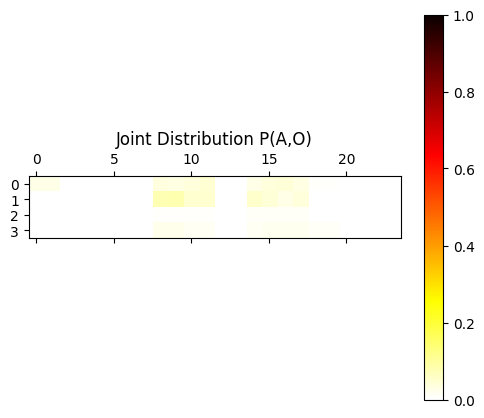

p_o: [3.28278214e-02 3.26668938e-02 1.07512707e-05 8.35699390e-06
 7.63488952e-06 6.57215556e-06 5.67463034e-06 6.80154740e-06
 1.34613930e-01 1.36952690e-01 1.09157641e-01 1.16211606e-01
 6.95073457e-06 7.99560527e-06 1.04663095e-01 1.05449858e-01
 9.36971919e-02 9.59720216e-02 1.85146772e-02 1.91857638e-02
 6.09736441e-06 7.89779499e-06 7.66895408e-06 4.40869553e-06]
H(O): 3.360042119670294
H(O|A): 3.269613769452559


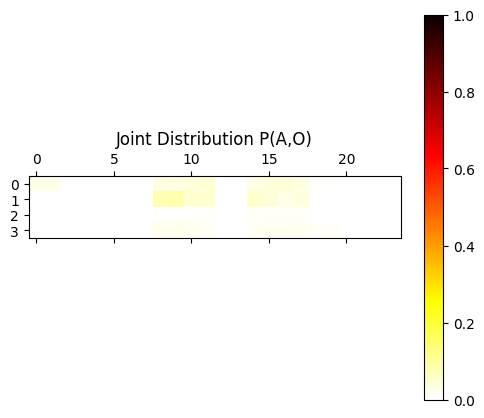

p_o: [3.28399502e-02 3.26784759e-02 1.07641560e-05 8.35669972e-06
 7.63882466e-06 6.57736825e-06 5.67543925e-06 6.81279427e-06
 1.34730732e-01 1.37101619e-01 1.09118470e-01 1.16204638e-01
 6.95278383e-06 8.00470162e-06 1.04493341e-01 1.05364346e-01
 9.35913344e-02 9.58783820e-02 1.86222772e-02 1.92895751e-02
 6.10154162e-06 7.89759923e-06 7.66961979e-06 4.40752944e-06]
H(O): 3.360479608701557
H(O|A): 3.270044701403018


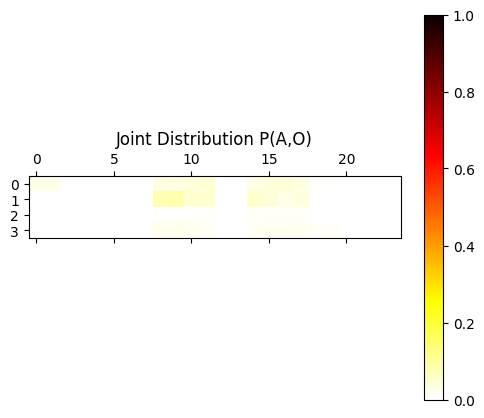

p_o: [3.28399508e-02 3.26784765e-02 1.07641561e-05 8.35669972e-06
 7.63882464e-06 6.57736825e-06 5.67543924e-06 6.81279427e-06
 1.34730732e-01 1.37101618e-01 1.09118470e-01 1.16204639e-01
 6.95278385e-06 8.00470164e-06 1.04493341e-01 1.05364346e-01
 9.35913347e-02 9.58783819e-02 1.86222771e-02 1.92895751e-02
 6.10154162e-06 7.89759924e-06 7.66961978e-06 4.40752945e-06]
H(O): 3.360479610894969
H(O|A): 3.2700447036126956


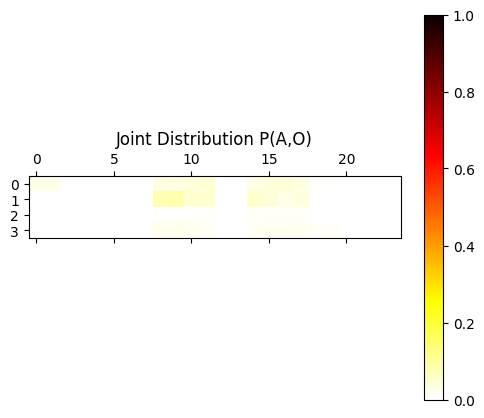

p_o: [3.28399498e-02 3.26784755e-02 1.07641560e-05 8.35669969e-06
 7.63882464e-06 6.57736824e-06 5.67543924e-06 6.81279424e-06
 1.34730733e-01 1.37101620e-01 1.09118470e-01 1.16204638e-01
 6.95278380e-06 8.00470159e-06 1.04493341e-01 1.05364346e-01
 9.35913340e-02 9.58783819e-02 1.86222770e-02 1.92895750e-02
 6.10154160e-06 7.89759920e-06 7.66961977e-06 4.40752943e-06]
H(O): 3.3604796059418063
H(O|A): 3.270044698636258


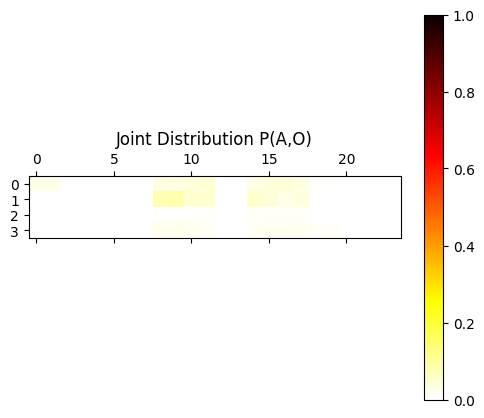

p_o: [3.28399500e-02 3.26784757e-02 1.07641560e-05 8.35669976e-06
 7.63882470e-06 6.57736827e-06 5.67543928e-06 6.81279427e-06
 1.34730731e-01 1.37101618e-01 1.09118470e-01 1.16204638e-01
 6.95278384e-06 8.00470163e-06 1.04493342e-01 1.05364346e-01
 9.35913351e-02 9.58783825e-02 1.86222771e-02 1.92895751e-02
 6.10154164e-06 7.89759927e-06 7.66961982e-06 4.40752947e-06]
H(O): 3.360479608815542
H(O|A): 3.2700447015282093


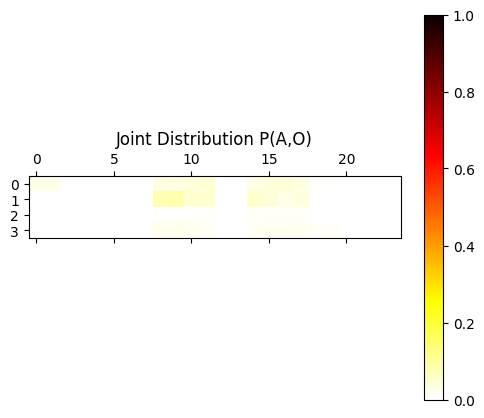

p_o: [3.28399500e-02 3.26784757e-02 1.07641561e-05 8.35669976e-06
 7.63882474e-06 6.57736831e-06 5.67543929e-06 6.81279434e-06
 1.34730732e-01 1.37101619e-01 1.09118470e-01 1.16204638e-01
 6.95278386e-06 8.00470168e-06 1.04493341e-01 1.05364346e-01
 9.35913346e-02 9.58783821e-02 1.86222778e-02 1.92895757e-02
 6.10154167e-06 7.89759928e-06 7.66961983e-06 4.40752947e-06]
H(O): 3.360479611198236
H(O|A): 3.2700447038799627


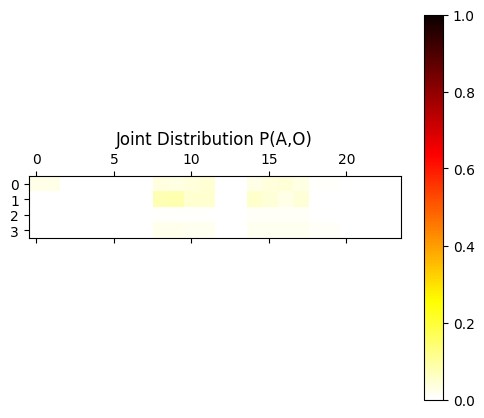

p_o: [3.27205697e-02 3.25584072e-02 1.07792507e-05 8.35787845e-06
 7.65284745e-06 6.58939954e-06 5.68003757e-06 6.83159232e-06
 1.35016610e-01 1.37456001e-01 1.09042066e-01 1.16122139e-01
 6.95400229e-06 8.01810932e-06 1.04320192e-01 1.05224774e-01
 9.33778504e-02 9.57681612e-02 1.88287379e-02 1.94775391e-02
 6.11043293e-06 7.89794983e-06 7.67415123e-06 4.40606368e-06]
H(O): 3.360774313146287
H(O|A): 3.270333154163419


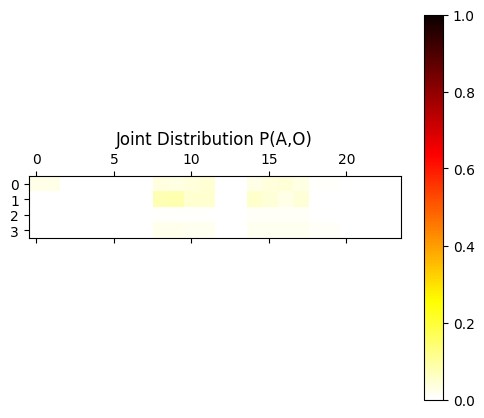

p_o: [3.27205703e-02 3.25584078e-02 1.07792508e-05 8.35787845e-06
 7.65284743e-06 6.58939953e-06 5.68003756e-06 6.83159232e-06
 1.35016609e-01 1.37456000e-01 1.09042066e-01 1.16122139e-01
 6.95400231e-06 8.01810933e-06 1.04320192e-01 1.05224774e-01
 9.33778508e-02 9.57681611e-02 1.88287378e-02 1.94775391e-02
 6.11043293e-06 7.89794984e-06 7.67415123e-06 4.40606369e-06]
H(O): 3.3607743153487273
H(O|A): 3.270333156368798


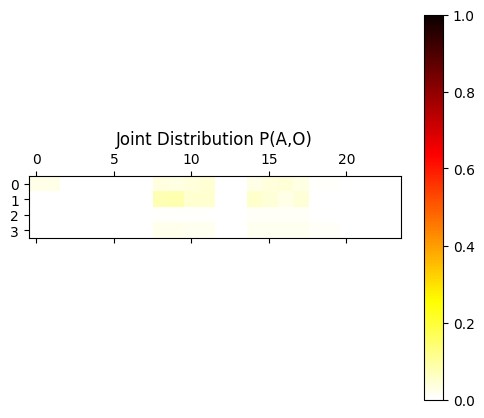

p_o: [3.27205693e-02 3.25584068e-02 1.07792507e-05 8.35787842e-06
 7.65284743e-06 6.58939953e-06 5.68003756e-06 6.83159229e-06
 1.35016611e-01 1.37456002e-01 1.09042066e-01 1.16122139e-01
 6.95400227e-06 8.01810928e-06 1.04320192e-01 1.05224774e-01
 9.33778500e-02 9.57681611e-02 1.88287377e-02 1.94775390e-02
 6.11043291e-06 7.89794980e-06 7.67415122e-06 4.40606366e-06]
H(O): 3.3607743103770815
H(O|A): 3.2703331513923604


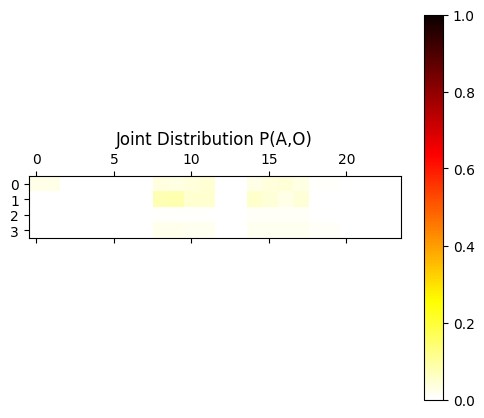

p_o: [3.27205696e-02 3.25584071e-02 1.07792507e-05 8.35787849e-06
 7.65284750e-06 6.58939956e-06 5.68003760e-06 6.83159232e-06
 1.35016609e-01 1.37456000e-01 1.09042066e-01 1.16122139e-01
 6.95400231e-06 8.01810932e-06 1.04320193e-01 1.05224775e-01
 9.33778512e-02 9.57681617e-02 1.88287379e-02 1.94775391e-02
 6.11043295e-06 7.89794987e-06 7.67415127e-06 4.40606371e-06]
H(O): 3.3607743132675583
H(O|A): 3.2703331542843115


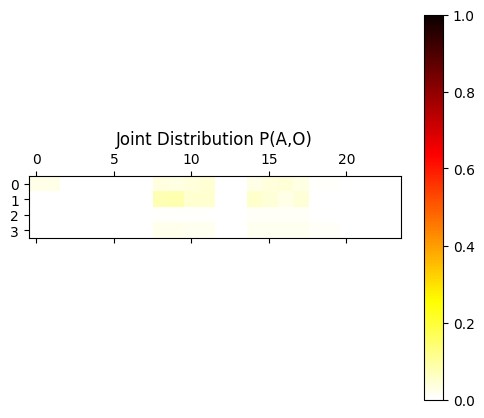

p_o: [3.27205696e-02 3.25584070e-02 1.07792508e-05 8.35787850e-06
 7.65284753e-06 6.58939959e-06 5.68003761e-06 6.83159239e-06
 1.35016610e-01 1.37456001e-01 1.09042066e-01 1.16122139e-01
 6.95400232e-06 8.01810938e-06 1.04320192e-01 1.05224774e-01
 9.33778506e-02 9.57681613e-02 1.88287385e-02 1.94775397e-02
 6.11043298e-06 7.89794988e-06 7.67415128e-06 4.40606370e-06]
H(O): 3.3607743156199743
H(O|A): 3.270333156636065


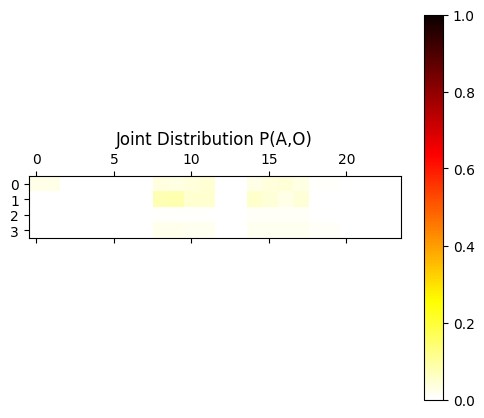

p_o: [3.27205697e-02 3.25584072e-02 1.07792507e-05 8.35787845e-06
 7.65284745e-06 6.58939954e-06 5.68003757e-06 6.83159232e-06
 1.35016610e-01 1.37456001e-01 1.09042066e-01 1.16122139e-01
 6.95400229e-06 8.01810932e-06 1.04320192e-01 1.05224774e-01
 9.33778504e-02 9.57681612e-02 1.88287379e-02 1.94775391e-02
 6.11043293e-06 7.89794983e-06 7.67415123e-06 4.40606368e-06]
H(O): 3.360774313146287
H(O|A): 3.270333154163419
Empowerment (max MI) = 0.0904 bits
Optimal P(A2) = [0.33795968 0.42567964 0.06385975 0.17250093]


In [ ]:
# Example usage with your existing data:
# Extract P(O|A) from your RDM


# Trace out O3 from rho_a2o3 to get rho_a2, then compute its eigenvalues
dim_a2 = p_a2o3.shape[0]
dim_o3 = p_a2o3.shape[1]

rho_a2 = rho_a2o3.reshape(dim_a2, dim_o3, dim_a2, dim_o3)
rho_a2 = np.trace(rho_a2, axis1=1, axis2=3)

# Enforce Hermiticity to avoid tiny numerical imag parts
rho_a2 = (rho_a2 + rho_a2.conj().T) / 2

eigvals = np.linalg.eigvalsh(rho_a2)
eigvals = np.real(eigvals)


# Extract marginal P(A2)
p_a2 = np.sum(p_a2o3, axis=1, keepdims=True)

# Compute mutual information
mi_a2_o3 = mutual_information(p_o3_given_a2, p_a2)
print(mi_a2_o3)
print(f"Mutual Information I(A2;O3) = {mi_a2_o3:.4f} bits")

# Compute empowerment (maximum MI)
empowerment_a2_o3, optimal_p_a2 = empowerment_classical(p_o3_given_a2)
print(f"Empowerment (max MI) = {empowerment_a2_o3:.4f} bits")
print(f"Optimal P(A2) = {optimal_p_a2}")

# Tasks for Benny

## Main objective is to extract Empowerment and Infogain for a Tmaze agent with traps and without.

### 1. Compute Empowerment between a1 and o2 and between a2 and o3
- One formula is the Quantum Mutual Information between these variables.
- For the classical formula we just need to extract $p( a | o ) $ and then compute the mutual information by taking the maximum over several choices of $p( a ) $ as the MI is the Shannon Entropy of $p( a ) $ minus Entropy of $p( a | o) $